In [529]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import os

print(tf.__version__)

2.5.0


In [530]:
from utils import *

In [531]:
# get data
xin_dataset = pd.read_csv(r'../no_backup/data/losses_bids_20210804-de+us+ru+jp_new.csv',low_memory=False)
#xin_dataset = pd.read_csv(r'../no_backup/data/losses_bids_20210705-de+us+ru+jp_new.csv',low_memory=False)
df = xin_dataset.copy()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345776 entries, 0 to 1345775
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   id                            1345776 non-null  object 
 1   ts                            1345776 non-null  object 
 2   wins                          1345776 non-null  int64  
 3   ad_size                       1345776 non-null  object 
 4   ad_type                       1345776 non-null  int64  
 5   country                       1345776 non-null  object 
 6   partner                       1345776 non-null  object 
 7   publisher_app                 1345776 non-null  object 
 8   bid_price                     1345776 non-null  int64  
 9   bid_price_eur                 1345776 non-null  int64  
 10  floor_price                   1345776 non-null  int64  
 11  floor_price_eur               1345776 non-null  int64  
 12  clearing_price              

(1345776, 20)

In [532]:
df.rename(columns={'minimum_bid_to_win': 'win_price'}, inplace=True)

In [533]:
# Sort data by time (test set will be latest observations)
df.sort_values("ts", inplace=True)

In [ ]:
df.head().T

# Feature Engineering
*'If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which **features** are the most meaningful to include, and how they should be represented.'*

`ad_size`: [an artical tells ad size does matter](https://gimbal.com/best-mobile-ad-formats/)

> `1200x627` is [only ad_size](https://remerge.atlassian.net/wiki/spaces/GLOS/pages/492437556/Native+Ads) for `native`.\
I will replace the `native` with  the `1200x627` for calculating the `ad_area` and the `ad_ratio`

> `findings`: #TODO width or height has the correlation with price?



`.str.split(): ` https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html
> 1. When using expand=True, the split elements will expand out into separate columns.
> 2. series should be converted to string before using the function



In [534]:
# ad_size


df['ad_size'] = df['ad_size'].replace('native','1200x627').replace('0x0','1x1')
df['ad_width'] = df['ad_size'].str.split('x',expand = True)[0].astype(int) # 'x' is the split condition
df['ad_height'] = df['ad_size'].str.split('x',expand = True)[1].astype(int)
df['ad_area'] = df['ad_width'] * df['ad_height']
df['ad_ratio']= np.log(df['ad_width']/df['ad_height'])
    

# Train/Validation/Test (time-separated)

In [535]:
# 60/20/20
from sklearn.model_selection import train_test_split

train,valid_test_df = train_test_split(df, test_size=0.4, shuffle=False) # 0.6/0.4
valid,test = train_test_split(valid_test_df, test_size=0.5, shuffle=False) # 40*0.5 for test

print(train.shape, valid.shape, test.shape)

(807465, 24) (269155, 24) (269156, 24)


# Bins

**`Notice`**: 

1. Johannes sets the range of predictions to the maximum possible range in the system as [0;132050000]. 
> currently the maximum bidding price `df['bid_price_eur'].max()` satisfy this predefined price range, **BUT the winning price `df['clearing_price_eur'].max()` is far above this price range setting.** (on the one hand I think it make sense because we don't know the true clearing_price_eur, on the other hand I am not sure after knowing the true maximum possible clearing_prie could be 22 times larger than 132050000, would 132050000 too small for a upper bidding price bound?)

2. `Max Winning Price` ≥ `Max Bidding Price` 
> take `>` when we lose the bid that cleared at a super high price\
> take `=` when we won the bid

3. Check the distribution of the raw win price and log win price.
> It seems that the winning price follows a log-normal distribution ? NO

4. Get cut points
> I have changed `maximum=max_win_price` to solve the consern in `1.`. The **reason is to keep the highest actual winning price information** in the model when cutting bins, although in most cases the bid landscape forcasting task will not take that information into consideration since rarely has bidding or winning price reach that high. After manually entering a very large upper bound, what appears immediately is that the last bin width becomes significantly larger. **Would that be a potential problem?** Yes, but the only impact is when you want to 99.99% win a high-valued bid, i.e. given the historical records and advertisement features the average bidding price to win such an impression is very high. Othewise you will never touch that extreme bidding price. There are other possible prices with the same win rate i.e. 99.99% in such a wide bin, **why it would return the upper bound of that bin?** To make sure you want a e.g. 60% win rate for a bid, the safe way is definitly returning the largest possible price, this applies to all bins.

In [536]:
# 1. check the max paying price # 
max_win_price = df['win_price'].max() # here: win_price = clearing_price_eur
min_win_price = df['win_price'].min()
print('Max Winning Price: ', max_win_price)
print('Min Winning Price: ', min_win_price)


max_bid_price = df['bid_price_eur'].max()
min_bid_price = df['bid_price_eur'].min()
print('Max Bidding Price: ', max_bid_price)
print('Min Bidding Price: ', min_bid_price)

Max Winning Price:  147058830000
Min Winning Price:  10000
Max Bidding Price:  100050000
Min Bidding Price:  8452


In [537]:
df['win_price'].nunique()

17542

In [538]:
# 2. Max Winning Price ≥ Max Bidding Price
#df[df['win_price']== max_win_price][['bid_price_eur','win_price','minimum_bid_to_win','wins']]
df[df['win_price']== max_win_price][['bid_price_eur','win_price','wins']]

,bid_price_eur,win_price,wins
1209669,86671,147058830000,0


In [539]:
# There are several expensive winning prices as the largest one -> 2951772531 is not an outlier!
df['win_price'].sort_values(ascending=False)

1209669    147058830000
525014     100000000000
344031       4161430000
413311       3828010000
666658       3032280000
               ...     
827442            10000
1032219           10000
323487            10000
864804            10000
1158518           10000
Name: win_price, Length: 1345776, dtype: int64

/home/xin/.conda/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/xin/.conda/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/xin/.conda/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

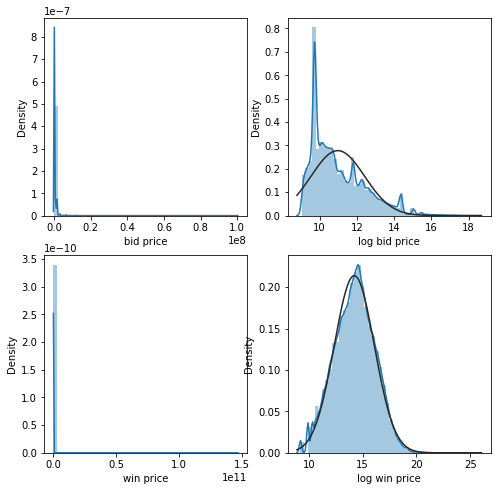

In [540]:
# 3. check the distribution of the raw win price and log win price;raw bid price and raw log bid price.
import seaborn as sns
from scipy.stats import norm


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))


bid_price_data = df['bid_price_eur']
bid_price_log_data = np.log(df['bid_price_eur'])
win_price_data = df['win_price']
win_price_log_data = np.log(df['win_price'])

sns.distplot(bid_price_data,axlabel = 'bid price',ax=axes[0,0])
sns.distplot(bid_price_log_data, fit=norm, axlabel = 'log bid price' ,ax=axes[0,1])
sns.distplot(win_price_data,axlabel = 'win price',ax=axes[1,0])
sns.distplot(win_price_log_data, fit=norm, axlabel = 'log win price' ,ax=axes[1,1])

plt.show()

In [541]:
# statistic test for log-normal(just for fun)
import scipy as sp
#a=df['win_price']
a= bid_price_log_data

p=sp.stats.mstats.normaltest(a, axis=0).pvalue
if p<0.1: # 0.05
   print ('distribution is not normal')
p=sp.stats.mstats.normaltest(np.log(a), axis=0).pvalue
if p<0.1: # 0.05
   print ('distribution is not log-normal')

distribution is not normal
distribution is not log-normal


In [558]:
# 4. get cut points

# choose one of the following price as the maximum
#max_price = df['bid_price_eur'].max()
max_price = df['win_price'].max()

cuts = cut_generator(ncut=70, minimum=0, maximum=max_win_price, seed=134, # ncut=50
                     empirical_data=train['win_price'], dist='empirical') 
print('No. of cuts before:', len(cuts))

# combine empty bins
cuts = cut_combiner(cuts, train['win_price'])
print('No. of cuts after: ', len(cuts))
print('Cuts: ', cuts.round(0))

bins = np.insert(cuts, 0, 0) # bins start from 0 with the number 0
bins = np.append(bins, max_price+1) # add max price as the the value of the last bin
print(bins)

No. of cuts before: 70
No. of cuts after:  61
Cuts:  [    50000     90000    110000    140000    150000    160000    180000
    200000    220000    250000    280000    290000    300000    380000
    420000    450000    500000    590000    640000    650000    690000
    740000    960000    990000   1090000   1170000   1190000   1290000
   1450000   2350000   2490000   2530000   2970000   3380000   3580000
   3790000   3870000   3970000   4050000   5474965   6230000   6870000
   7050000   7130000   7950000   8199999   8630000   9350000  10890000
  12500000  12670000  13550000  14300000  14790000  16690000  20930000
  30150000  57890000  66067929 121979183 141347565]
[           0        50000        90000       110000       140000
       150000       160000       180000       200000       220000
       250000       280000       290000       300000       380000
       420000       450000       500000       590000       640000
       650000       690000       740000       960000       9900

#  Input/TF Dataset and Preprocessing Layers

- Code copied from https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- Feature columns from the TF tutorial doesn't work https://www.tensorflow.org/tutorials/structured_data/feature_columns


An outline of tasks in this part
2.1 Data type processing

2.2 Pandas dataframe -> tf.dataset
- no censoring: `df_to_dataset()`. Labels with 1 column in one-hot coding form win_price
- with censoring: `df_to_dataset_censored()`. Labels with 2 columns,both as bin numbers without one-hot ???
       
    split X and y. 
    **y**: different from the non-censored case that only have one target varible(the winning price of the winner), in the censored case we deal with the censoring by the custom loss function, two prices are requied: `minimum_bid_to_win` and `bid_price_eur`. `minimum_bid_to_win` contains the second highest price for the winners and the highest price for the losers. 

- `labels = dataframe[['minimum_bid_to_win', 'bid_price_eur']].copy()`. We need `bid_price_eur`for our censored loss function $\Rightarrow$ information in labels are data passing into y_true for the censored loss function. The `minimum_bid_to_win` is the second highest price for the winners, which are used for calculating the binary loss for them (similar to the non-censored case). The bidding prices are there for both the winners and the losers, for calculating the cross-entropy loss. Whether a bid is winning or losing can be tell from the minimum_bid_to_win and bid_price_eur: if bid > min, then it's winning, then both binary and CE losses are applied. 


`minimum_bid_to_win` contains the optimal price we should bid. It is clear for winning bids, however for lose bid it is quite tricky to think the highest price (`minimum_bid_to_win` returns the bid price of the winner in the same auction) as the optimal price to win. Assume we have a perfect model always returns a correct bidding price. If we have two records in the history bidding logs: one win bid with 5 cent and one lose bid with 2 cent, the `minimum_bid_to_win` returns for the win bid is 3 cent and for the lose bid with 5 cent. Now it comes a new chance with exactly same ad and user feature, the question is: which price should the perfect model return? 5cenr  or 3 cent? My suggestion is in the `minimum_bid_to_win` only contains the second highest price. e.g. 3 cent for both win and lose bids and ignore the 5 cent, the argument is for an aution it should only have one ground-truth for all participants in the same auction.

(Addtionnal notes: why the `minimum_bid_to_win` is not the optimal price for lose bids. e.g. after knowing that 5cent is the price of the winner, to win auction the loser need to bid 5.01cent, this changes the overall second winning price from 3cent to 5cent.)


   >> `labels = np.digitize(labels, cuts)` not bins but cuts (see coding)
 
  

> 2.3 preprocessing layer (functions are in the utils)



In [559]:
# 2.1 dtype processing: 
## 1). object -> string
## 2). fill NA values '<NA>' before input to pre-processing layers

def feature_dtype_preprocess(df):
    df = df.copy()
    for col in df.columns:
        if df.dtypes[col] == 'O':     # df.dtypes[df.columns[1]] -> dtype('O')
            df[col]= df[col].astype('string')  # convert object to string
            df[col].fillna('', inplace = True) # if string type has NA as: <NA> and doesn't work in TF
        
    return df  # here also can return df
    

In [560]:
# convert the data type seperatly
train = feature_dtype_preprocess(train)
valid = feature_dtype_preprocess(valid)
test = feature_dtype_preprocess(test)

## FUNCTION/ df_to_tf_censored()

In [561]:
# 2.2 Pandas dataframe -> tf.dataset (function) 

def df_to_tf_censored(dataframe, cuts, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe[['win_price','bid_price_eur']].copy() # y_true for loss function. Order does matter!
    dataframe = dataframe.drop(columns=['win_price','bid_price_eur'])  
    
    labels = np.digitize(labels, cuts)
    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)) # ((.)): method takes 1 positional argument 
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size) # speed up
    return ds

In [562]:
# Coding: why cuts not bins in `labels = np.digitize(labels, cuts)`
# in https://numpy.org, it name the 2nd argument as bins: np.digitize(labels, bins). 
# I think it should be cuts, since 5 cuts means 6 bins not 4 bins
# x = np.array([[-0.01, 0, 0.2, 6.4,3.0, 9.9, 10, 16]])
# cuts = np.array([0.0, 1.0, 2.5, 4.0, 10.0]) 
# np.digitize(x, cuts) # [0.0, 1.0)

In [563]:
# Pandas dataframe -> tf.dataset

train_ds = df_to_tf_censored(dataframe = train, cuts = cuts, shuffle = False, batch_size = 4096)
valid_ds = df_to_tf_censored(dataframe = valid, cuts = cuts, shuffle = False, batch_size = 4096)
test_ds = df_to_tf_censored(dataframe = test, cuts = cuts, shuffle = False, batch_size = 4096)
win_ds = df_to_tf_censored(dataframe = test.loc[test.wins==1], cuts = cuts, shuffle = False, batch_size = 4096)

In [114]:
test.loc[test.wins==1]

,id,ts,wins,ad_size,ad_type,country,partner,publisher_app,bid_price,bid_price_eur,...,exchange_rate,second_highest_bid_price,second_highest_bid_price_eur,win_price,adx_loss_reason,winning_bid,ad_width,ad_height,ad_area,ad_ratio
245394,SXpRtZiXtNIvyksm,2021-08-06 18:43:27+00:00,1,320x50,4,ru,adx,com.lihuhu.woodblockmerger,11165,9435,...,0.845052,20000,16900,20000,1,20000,320,50,16000,1.856298
654908,M6znqziZSM5GqkYH,2021-08-06 18:43:28+00:00,1,412x837,4,de,adx,com.bigcake.android.mergemania,2300000,1943591,...,0.845040,2300000,1943591,2300000,1,2300000,412,837,344844,-0.708801
1107175,zFy5ys30KgjY1aDZ,2021-08-06 18:43:29+00:00,1,320x50,1,de,adx,com.gma.ball.sort.puzzle,258475,218422,...,0.845041,180000,152107,180000,1,180000,320,50,16000,1.856298
1234075,eGbfbfNaKvnZzIom,2021-08-06 18:43:32+00:00,1,320x50,1,de,adx,com.addswhilessuffers.binds,250000,211259,...,0.845036,250000,211259,250000,1,250000,320,50,16000,1.856298
250872,JV1ict16tDIhJfKa,2021-08-06 18:43:32+00:00,1,320x50,4,ru,adx,puzzle.blockpuzzle.cube.relax,20783,17563,...,0.845066,20000,16900,20000,1,20000,320,50,16000,1.856298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961103,iovllP0kzI4kAtn8,2021-08-06 23:59:46+00:00,1,320x480,4,ru,adx,io.hexman.xiconchanger,354133,299257,...,0.845041,350000,295763,350000,1,350000,320,480,153600,-0.405465
536235,lSRc8GsSCeXguN7h,2021-08-06 23:59:46+00:00,1,414x50,1,us,adx,1299421779,1553959,1313158,...,0.845040,1340000,1132353,1340000,1,1340000,414,50,20700,2.113843
729354,YaP71BMG72zooSZD,2021-08-06 23:59:51+00:00,1,320x50,1,jp,adx,yudo.work.saitosan,57778,48825,...,0.845045,20000,16900,20000,1,20000,320,50,16000,1.856298
832652,qJK0FllF9ZWuRsiW,2021-08-06 23:59:54+00:00,1,1200x627,2,jp,adx,game.puzzle.woodypuzzle,8840000,7470153,...,0.845040,8830000,7461702,8830000,1,8830000,1200,627,752400,0.649130


In [ ]:
# 2.3 Assemble Pre-processing Layers and Encode Data
# This is the last step before setting up the NN

In [564]:
all_inputs = []       # pre-processing layer
encoded_features = [] # encoding input data

In [565]:
# Nummeric features
for header in tqdm(['ad_width','ad_height','ad_area','ad_ratio']): # 'floor_price_eur'
    numeric_col = tf.keras.Input(shape = (1,), name = header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)
    
    

100%|█████████████████████████████████████████████| 4/4 [00:33<00:00,  8.47s/it]


In [566]:
# Categorical features encoding with hashing and embedding
# String Categorial features encoded with hashing
for header in tqdm(['ad_size','country']): # ts is unique. no publisher_app 'ts'
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    # encoding_layer = get_category_hashing_layer(header, train_ds, num_bins = 10_000) # IP
    encoding_layer = get_hashing_embedding_layer(header, train_ds, dtype='string', max_tokens=None, output_dim=32) # hashing - embedding
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

100%|█████████████████████████████████████████████| 2/2 [00:17<00:00,  8.97s/it]


In [567]:
# Categorical features encoded as integers
for header in tqdm(['ad_type']): 
    numeric_cat_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64', max_tokens=4) #5
    encoded_cat_col = encoding_layer(numeric_cat_col)
    all_inputs.append(numeric_cat_col)
    encoded_features.append(encoded_cat_col)

100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


# NN model

In [568]:
# 1. Network Setup
num_bins = len(cuts) + 1 # how many output neurons are needed
print(num_bins)

62


In [569]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

x = tf.keras.layers.concatenate(encoded_features)

num_layer_blocks = 3
num_neurons = [200,100,100]

for i in range(num_layer_blocks):
    x = Dense(num_neurons[i], 
              kernel_initializer = 'he_uniform', # kernel_regularizer = 'l2',
              kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
              activation='LeakyReLU')(x) # LeakyReLU is better than ReLU, 1 layer is enough

    x = BatchNormalization()(x)
    x = Dropout(0.25)(x) # 0.5

output = Dense(num_bins,
               kernel_initializer = 'he_uniform',
               activation='softmax')(x)

model = tf.keras.Model(all_inputs, output)

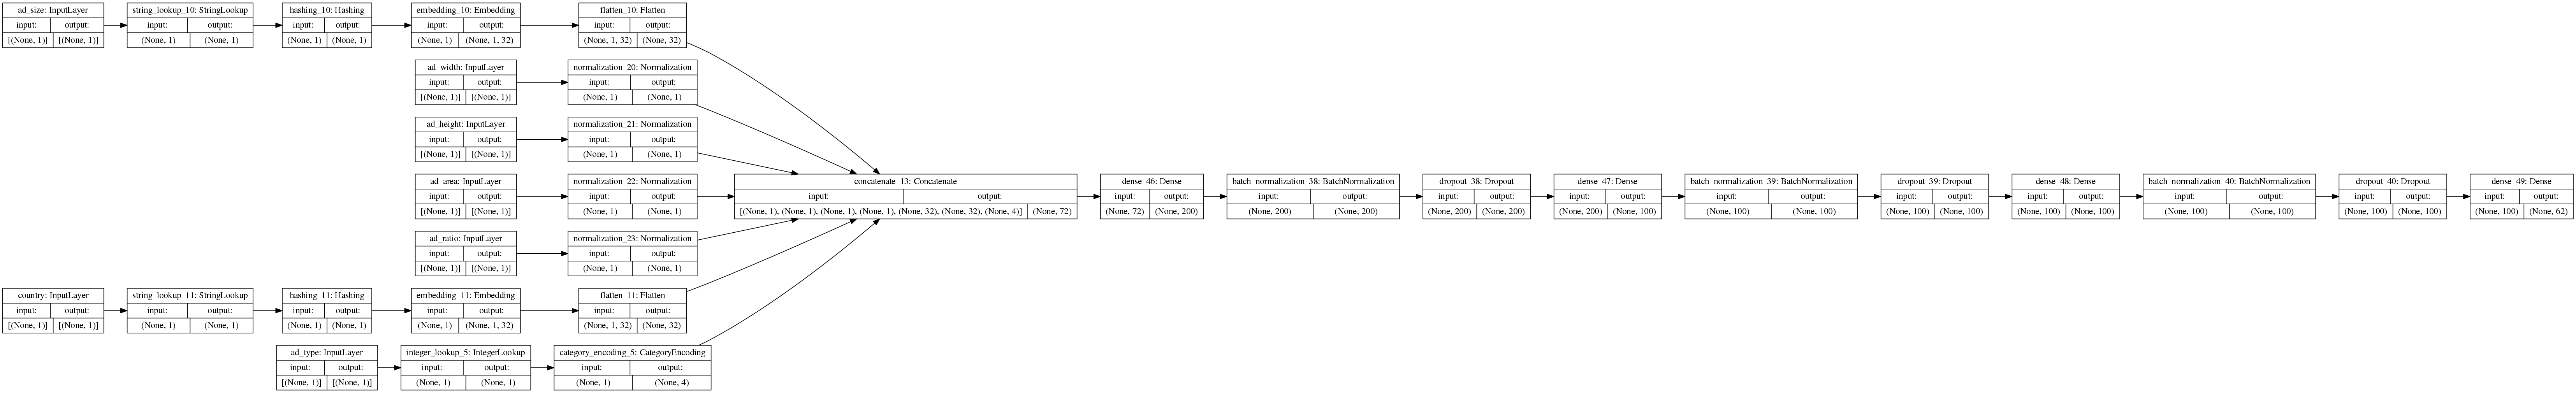

In [570]:
# plot the model

##still doesn't work here
# file_name = 'model_'+datetime.datetime.now().strftime('%Y-%m%d-%H.%M.%S')+'.png'
# tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, rankdir="LR", to_file=file_name, dpi=120)
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, rankdir="LR", dpi=120)

# The custom Loss function

The censored loss function has two y_true = [`minimum_bid_to_win`,`bid_price_eur`]
**Idea is similar to Ren et al. 2019's Deep Landscape Forcasting**: 
> **The final loss is the weighted sum of two parts:**

1. **Binary cross entropy (PDF)** from the `minimum_bid_to_win`, if cencored = True, then losing bids are cencored.
censoring means losing bids don't know the **2nd highest winning price**

2. **Cross entropy from bidding price (cumsum,CDF)**. Losing bids have losses from all bins incl. and lower than the bidding price, and winning bids have losses from bins inclu. and above the bidding price.
  - Winning CE: y_true.cumsum * log(y_pred.cumsum)
  - Losing CE: (1-y_true.cumsum + y_true) * log(1 - y_pred.cumsum)


In [ ]:
y_hat=tf.constant([[0.3, 0.4,0.3], [0.1, 0.8,0.1],[0.3,0.6,0.1]])
y = tf.constant([[0.0, 0.0, 1.0], [0.0, 1.0,0.0],[0.0,1.0,0.0]])
print(y)

y_cum= tf.cumsum(y,axis =1)
y_hat_cum = tf.cumsum(y_hat,axis =1)
print(y_hat_cum)

def test_ce(p,t):
    
    y_hat_cum = tf.cumsum(p,axis =1)
    y_cum= tf.cumsum(t,axis =1)
    
    ce = -tf.reduce_sum(y_cum*tf.math.log(y_cum))
    return ce

        

In [ ]:
a = tf.constant([0,0.8,0.2])
aa= tf.constant([0.0,1.0,0.0])

#tf.reduce_sum(a * tf.math.log(aa))
#test_ce(y_hat,y)
a_cum= tf.math.cumsum(a, axis=-1)
aa_cum=tf.math.cumsum(aa, axis = -1)
#a_cum=tf.clip_by_value(a_cum, 1e-7, 1-1e-7)
aa_cum=tf.clip_by_value(aa_cum, 1e-7, 1-1e-7)

-tf.reduce_sum(tf.math.log(aa_cum) * a_cum, axis=-1)

In [ ]:
def my_censored_binary_loss(ce_loss_weight = 0.25, censored = True):

    def my_binary_loss(y_true, y_pred):
        market_price = y_true[:, 0]
        bid_price = y_true[:, 1]
        winning = tf.cast(bid_price > market_price, tf.float32) # tf calculation requires float * float (not float * int) 

        num_bins = tf.cast(y_pred.shape[-1], tf.int32)
        market_one_hot = tf.one_hot(market_price, depth=num_bins)
        bid_one_hot = tf.one_hot(bid_price, depth=num_bins)
        
        clipped_y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7) # why 1e-7? 1e-10 is too small for logarithmus -> nan (also in Ren et al.)
        cumsum_y_pred  = tf.clip_by_value(tf.math.cumsum(y_pred, axis=-1), 1e-7, 1 - 1e-7)

        if censored:
            # Losing bids are censored: don't know the true market price -> don't count their NLL loss
            binary_loss =  -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot, 
                                          axis=-1) * winning
            binary_loss += -tf.reduce_sum(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot), 
                                          axis=-1) * winning 
            binary_loss = tf.reduce_sum(binary_loss)
        else:
            binary_loss =  -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot)
            binary_loss += -tf.reduce_sum(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot))
        
        winning_CE = tf.reduce_sum(
            tf.math.cumsum(bid_one_hot, axis=-1) * -tf.math.log(cumsum_y_pred), # maybe using market_one_hot is a better idea
            axis = -1
        )
        losing_CE = tf.reduce_sum(
            (1 - tf.math.cumsum(bid_one_hot, axis=-1) + bid_one_hot) * -tf.math.log(1 - cumsum_y_pred)\
            + tf.math.cumsum(market_one_hot, axis=-1) * -tf.math.log(cumsum_y_pred), # (1 - bid.cumsum + bid) * (1 - pred)
            axis = -1
        )
        cross_entropy = tf.reduce_sum(
            winning * winning_CE + (1-winning) * losing_CE
        )
        
        combined_loss = (1.0-ce_loss_weight) * binary_loss + ce_loss_weight * cross_entropy
        return combined_loss
    return my_binary_loss

In [ ]:
def m_censored_binary_loss(ce_loss_weight = 0.25, censored = True):

    def my_binary_loss(y_true, y_pred):
        market_price = y_true[:, 0]
        bid_price = y_true[:, 1]
        winning = tf.cast(bid_price > market_price, tf.float32) # tf calculation requires float * float (not float * int) 

        num_bins = tf.cast(y_pred.shape[-1], tf.int32)
        market_one_hot = tf.one_hot(market_price, depth=num_bins)
        bid_one_hot = tf.one_hot(bid_price, depth=num_bins)
        
        clipped_y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7) # why 1e-7? 1e-10 is too small for logarithmus -> nan (also in Ren et al.)
        cumsum_y_pred  = tf.clip_by_value(tf.math.cumsum(y_pred, axis=-1), 1e-7, 1 - 1e-7)

        if censored:
            # Losing bids are censored: don't know the true market price -> don't count their NLL loss
            binary_loss =  -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot, 
                                          axis=-1) * winning
            binary_loss += -tf.reduce_sum(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot), 
                                          axis=-1) * winning 
            binary_loss = tf.reduce_sum(binary_loss)
        else:
            binary_loss =  -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot)
            binary_loss += -tf.reduce_sum(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot))
        
        winning_CE = tf.reduce_sum(
            tf.math.cumsum(bid_one_hot, axis=-1) * -tf.math.log(cumsum_y_pred), # maybe using market_one_hot is a better idea
            axis = -1
        )
        losing_CE = tf.reduce_sum(
            (1 - tf.math.cumsum(bid_one_hot, axis=-1) + bid_one_hot) * -tf.math.log(1 - cumsum_y_pred), # (1 - bid.cumsum + bid) * (1 - pred)
            axis = -1
        )
        cross_entropy = tf.reduce_sum(
            winning * winning_CE + (1-winning) * losing_CE
        )
        
        combined_loss = (1.0-ce_loss_weight) * binary_loss + ce_loss_weight * cross_entropy
        return combined_loss
    return my_binary_loss

In [ ]:
def _censored_binary_loss(ce_loss_weight = 0.25, censored = True):

    def my_binary_loss(y_true, y_pred):
        market_price = y_true[:, 0]
        bid_price = y_true[:, 1]
        winning = tf.cast(bid_price > market_price, tf.float32) # tf calculation requires float * float (not float * int) 

        num_bins = tf.cast(y_pred.shape[-1], tf.int32)
        market_one_hot = tf.one_hot(market_price, depth=num_bins)
        bid_one_hot = tf.one_hot(bid_price, depth=num_bins)
        
        clipped_y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7) # why 1e-7? 1e-10 is too small for logarithmus -> nan (also in Ren et al.)
        cumsum_y_pred  = tf.clip_by_value(tf.math.cumsum(y_pred, axis=-1), 1e-7, 1 - 1e-7)

        if censored:
            # Losing bids are censored: don't know the true market price -> don't count their NLL loss
            binary_loss =  -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot, 
                                          axis=-1) * winning
            binary_loss += -tf.reduce_sum(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot), 
                                          axis=-1) * winning 
            binary_loss = tf.reduce_sum(binary_loss)
        else:
            binary_loss =  -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot)
            binary_loss += -tf.reduce_sum(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot))
        
        winning_CE = tf.reduce_sum(
            bid_one_hot * -tf.math.log(cumsum_y_pred), # maybe using market_one_hot is a better idea
            axis = -1
        )
        losing_CE = tf.reduce_sum(
            bid_one_hot    * -tf.math.log(1 - cumsum_y_pred) +\
            market_one_hot * -tf.math.log(cumsum_y_pred), # bid * log (1 - pred) + market * log (pred)
            axis = -1
        )
        cross_entropy = tf.reduce_sum(
            winning * winning_CE + (1-winning) * losing_CE
        )
        
        combined_loss = (1.0-ce_loss_weight) * binary_loss + ce_loss_weight * cross_entropy
        return combined_loss
    return my_binary_loss

In [571]:
# test
def my_censored_binary_loss(ce_loss_weight = 0.25, censored = True):

    def my_binary_loss(y_true, y_pred):
        market_price = y_true[:, 0]
        bid_price = y_true[:, 1]
        winning = tf.cast(bid_price > market_price, tf.float32) # tf calculation requires float * float (not float * int) 

        num_bins = tf.cast(y_pred.shape[-1], tf.int32)
        market_one_hot = tf.one_hot(market_price, depth=num_bins)
        bid_one_hot = tf.one_hot(bid_price, depth=num_bins)
        
        clipped_y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7) # why 1e-7? 1e-10 is too small for logarithmus -> nan (also in Ren et al.)
        cumsum_y_pred  = tf.clip_by_value(tf.math.cumsum(y_pred, axis=-1), 1e-7, 1 - 1e-7)

        if censored:
            # Losing bids are censored: don't know the true market price -> don't count their NLL loss
            binary_loss =  -tf.reduce_mean(tf.math.log(clipped_y_pred) * market_one_hot, 
                                          axis=-1) * winning
            binary_loss += -tf.reduce_mean(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot), 
                                          axis=-1) * winning 
            binary_loss = tf.reduce_mean(binary_loss)
        else:
            binary_loss =  -tf.reduce_mean(tf.math.log(clipped_y_pred) * market_one_hot)
            binary_loss += -tf.reduce_mean(tf.math.log(1 - clipped_y_pred) * (1 - market_one_hot))
        
        winning_CE = tf.reduce_mean(
            tf.math.cumsum(bid_one_hot, axis=-1) * -tf.math.log(cumsum_y_pred), # maybe using market_one_hot is a better idea
            axis = -1
        )
        losing_CE = tf.reduce_mean(
            (1 - tf.math.cumsum(bid_one_hot, axis=-1) + bid_one_hot) * -tf.math.log(1 - cumsum_y_pred)\
            + tf.math.cumsum(market_one_hot, axis=-1) * -tf.math.log(cumsum_y_pred), # (1 - bid.cumsum + bid) * (1 - pred)
            axis = -1
        )
        cross_entropy = tf.reduce_mean(
            winning * winning_CE + (1-winning) * losing_CE
        )
        
        combined_loss = (1.0-ce_loss_weight) * binary_loss + ce_loss_weight * cross_entropy
        return combined_loss
    return my_binary_loss

---

# Evaluation matrics: CRPS

In [572]:
# From Li/ dcdr model
def crps_loss(y_true, y_pred):
        loss = 0
        clipped_y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)    
        loss += tf.reduce_mean(tf.square(1-clipped_y_pred) * y_true)
        loss += tf.reduce_mean(tf.square(clipped_y_pred) * (1 - y_true))
        return loss

In [573]:
def my_crps_loss(y_true, y_pred):
    market_price = tf.cast(y_true[:, 0], tf.int32)
    num_bins = tf.cast(y_pred.shape[-1], tf.int32)
    market_one_hot = tf.one_hot(market_price, depth=num_bins)
    
    return crps_loss(market_one_hot, y_pred)

# Evaluation matrics: ANLP

Different papers define ANLP differently. Here I use Ren et al.'s version.

Ren et al. use ANLP to access the likelihood of the co-occurence of the test bid requests with the corresponding matket prices $ANLP= -\frac{1}{|D_{test}|}\sum\limits_{(x^i, z^i)\in D_{test}}log p_z(z^i|x^i)$, $p_z(z^i|x^i)$ is the bin probability. ANLP only used in the pdf of the win bids

Ghosh et al. use ANLP to learn the distribution of the winning oricem rather than the point estimate.(the author use ANLP in both win and losing bids)

Wang et al. use ANLP to measure the forcasting error.(used in each subgroup)

In [574]:
# anlp is categorical cross entropy over winning bids
def anlp(y_true, y_pred):
    loss=0
    
    market_price = tf.cast(y_true[:, 0],tf.int32)
    bid_price = tf.cast(y_true[:, 1],tf.int32)
    winning = tf.cast(bid_price > market_price, tf.float32)
    
    num_bins = tf.cast(y_pred.shape[-1], tf.int32)
    market_one_hot = tf.one_hot(market_price, depth=num_bins)
    
        
    clipped_y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    loss += -tf.reduce_sum(tf.math.log(clipped_y_pred) * market_one_hot,axis=-1)
    loss = tf.reduce_sum(loss * winning)
    loss /= tf.reduce_sum(winning)
  
    return loss

In [507]:
yt = tf.constant([
    [1, 2],
    [2, 0]
], tf.int32)

yp = tf.constant([
    [0, .5, .5],
    [.5, .5, 0]
])

print(np.log(.5))
anlp(yt, yp).numpy()

-0.6931471805599453


0.6931472

In [497]:
y = tf.constant([0, 1, 1], tf.float32)
x = tf.constant([2, .5, 1], tf.float32)
z = tf.transpose(tf.tile([x], tf.constant([2, 1])))
print(
    tf.reduce_mean(y).numpy(),
    tf.reduce_mean(x*y).numpy(),
    z,
    y,
    tf.reduce_mean(z, axis=-1) * y  
)


0.6666667 0.5 tf.Tensor(
[[2.  2. ]
 [0.5 0.5]
 [1.  1. ]], shape=(3, 2), dtype=float32) tf.Tensor([0. 1. 1.], shape=(3,), dtype=float32) tf.Tensor([0.  0.5 1. ], shape=(3,), dtype=float32)


# Evaluation matrics: KL divergence(relative entropy)
https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence

The Kullback-Leibler Divergence score, or KL divergence score, quantifies how much one probability distribution differs from another probability distribution.

In [575]:
# not sure correct?
def kl(y_true, y_pred):
    
    market_price = tf.cast(y_true[:, 0], tf.int32)
    num_bins = tf.cast(y_pred.shape[-1], tf.int32)
    market_one_hot = tf.one_hot(market_price, depth=num_bins)
    
    cumsum_y_pred  = tf.clip_by_value(tf.math.cumsum(y_pred, axis=-1), 1e-7, 1 - 1e-7)
    cumsum_y_true  = tf.clip_by_value(tf.math.cumsum(market_one_hot, axis=-1), 1e-7, 1 - 1e-7)
    
    
    kl = tf.keras.losses.KLDivergence()
    score = kl(cumsum_y_true, cumsum_y_pred)
    return score

# Trainning and Prediction

In [576]:
from tensorflow.keras.metrics import categorical_accuracy


logdir = 'logs/scalars' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)


#top_5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5) # treated as correct prediction: got one of the highest prob.


2021-08-16 08:47:20.473143: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-16 08:47:20.473206: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-16 08:47:20.473442: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [354]:
# IF 1. y_true has one column
#model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_2=0.99, clipvalue=5.0), # learning_rate=1e-4, beta_2=0.99, clipvalue=5.0 /  learning_rate=1e-4 too slow
#              loss = 'BinaryCrossentropy', # binary_loss, crps_loss,cdf_loss,my_loss
#              metrics =  [binary_loss, crps_loss, 'BinaryCrossentropy', 'CategoricalCrossentropy', 
#                          top_5_accuracy, categorical_accuracy])

In [706]:
# IF 2. y_true has two columns
model.compile(optimizer = tf.optimizers.Adam(learning_rate=1e-4, beta_2=0.99, clipvalue=5.0), # learning_rate=1e-4, beta_2=0.99, clipvalue=5.0 /  learning_rate=1e-4 too slow
              loss = my_censored_binary_loss(ce_loss_weight = 0.75, censored = False),
              metrics=[my_crps_loss,anlp,kl]
             ) # binary_loss, crps_loss,cdf_loss,my_loss

In [707]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

training_history = model.fit(train_ds, epochs=15, 
                    callbacks=[callback, tensorboard_callback], 
                    validation_data=valid_ds)

Epoch 1/15


/home/xin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['id', 'ts', 'wins', 'partner', 'publisher_app', 'bid_price', 'floor_price', 'floor_price_eur', 'clearing_price', 'clearing_price_eur', 'exchange_rate', 'second_highest_bid_price', 'second_highest_bid_price_eur', 'adx_loss_reason', 'winning_bid'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


198/198 [==============================] - 21s 75ms/step - loss: 0.0688 - my_crps_loss: 0.0163 - anlp: 3.9142 - kl: 1.8554 - val_loss: 0.0664 - val_my_crps_loss: 0.0159 - val_anlp: 3.8032 - val_kl: 2.1895
Epoch 2/15
198/198 [==============================] - 14s 70ms/step - loss: 0.0680 - my_crps_loss: 0.0163 - anlp: 3.9305 - kl: 1.7758 - val_loss: 0.0658 - val_my_crps_loss: 0.0159 - val_anlp: 3.8151 - val_kl: 2.1086
Epoch 3/15
198/198 [==============================] - 14s 72ms/step - loss: 0.0677 - my_crps_loss: 0.0162 - anlp: 3.9329 - kl: 1.7528 - val_loss: 0.0660 - val_my_crps_loss: 0.0159 - val_anlp: 3.7980 - val_kl: 2.2054
Epoch 4/15
198/198 [==============================] - 14s 72ms/step - loss: 0.0675 - my_crps_loss: 0.0162 - anlp: 3.9317 - kl: 1.7387 - val_loss: 0.0655 - val_my_crps_loss: 0.0159 - val_anlp: 3.8072 - val_kl: 2.1169
Epoch 5/15
198/198 [==============================] - 14s 73ms/step - loss: 0.0674 - my_crps_loss: 0.0162 - anlp: 3.9321 - kl: 1.7274 - val_loss: 0

In [580]:
# check the loss and evaluation metrics in the train & valid
hist = pd.DataFrame(training_history.history)
hist['epoch'] = training_history.epoch
hist.tail()

,loss,my_crps_loss,anlp,kl,val_loss,val_my_crps_loss,val_anlp,val_kl,epoch
10,0.235581,0.015923,3.846291,3.364402,0.190673,0.015473,3.600942,4.453892,10
11,0.157207,0.015789,3.762569,3.338105,0.130263,0.015449,3.592553,4.158198,11
12,0.112006,0.015691,3.717008,3.279763,0.096404,0.015437,3.603502,3.639476,12
13,0.089383,0.015665,3.698902,3.213596,0.081462,0.015416,3.620992,3.610588,13
14,0.079943,0.015657,3.690139,3.160862,0.076218,0.015416,3.624513,3.526955,14


In [581]:
model.evaluate(test_ds)

66/66 [==============================] - 3s 46ms/step - loss: 0.0776 - my_crps_loss: 0.0154 - anlp: 3.6490 - kl: 3.8007


[0.07756388932466507,
 0.015448817983269691,
 3.6489713191986084,
 3.800715208053589]

In [582]:
predictions = model.predict(test_ds)
predictions.shape

/home/xin/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:588: UserWarning: Input dict contained keys ['id', 'ts', 'wins', 'partner', 'publisher_app', 'bid_price', 'floor_price', 'floor_price_eur', 'clearing_price', 'clearing_price_eur', 'exchange_rate', 'second_highest_bid_price', 'second_highest_bid_price_eur', 'adx_loss_reason', 'winning_bid'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


(269156, 62)

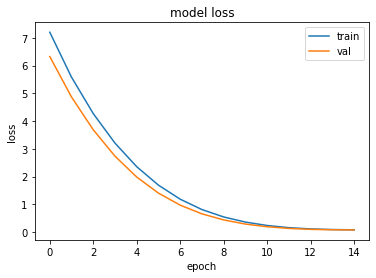

In [583]:
# plot the model loss in train and validation sets
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show() 

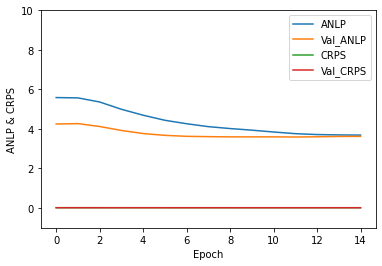

In [584]:
def plot_history(hist:pd.DataFrame) -> None:
    """
    Plot training vs. validation ANLP over epoch.
    """
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('ANLP & CRPS')
    plt.plot(hist['epoch'], hist['anlp'], label = 'ANLP')
    plt.plot(hist['epoch'],hist['val_anlp'],label = 'Val_ANLP')
    plt.plot(hist['epoch'], hist['my_crps_loss'], label = 'CRPS')
    plt.plot(hist['epoch'],hist['val_my_crps_loss'],label = 'Val_CRPS')
    plt.ylim([-1,10])
    plt.legend()
    plt.show()
    
    
plot_history(hist)

No handles with labels found to put in legend.


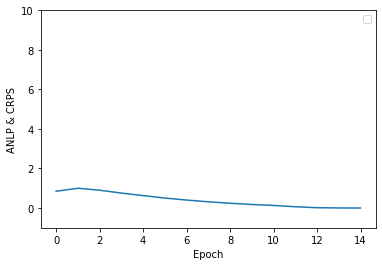

No handles with labels found to put in legend.


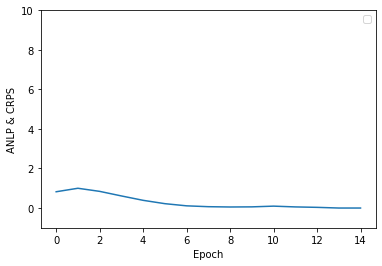

No handles with labels found to put in legend.


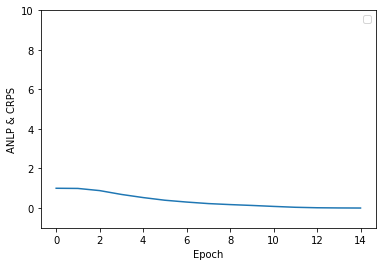

No handles with labels found to put in legend.


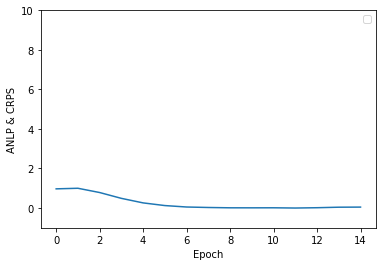

In [745]:
from sklearn.preprocessing import MinMaxScaler



def plot_history(hist:pd.DataFrame) -> None:
    """
    Plot training vs. validation ANLP over epoch.
    """
    # define min max scaler
    scaler = MinMaxScaler()
    # transform data
    data = ['my_crps_loss','val_my_crps_loss','anlp','val_anlp']
    
    for i in data:
        scaled=pd.DataFrame()
        df = pd.DataFrame(hist[i])
        scaled[[i]] = scaler.fit_transform(df)
        #print(scaled)
    
    
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('ANLP & CRPS')
    
    
        plt.plot(hist['epoch'], scaled[[i]])
        plt.ylim([-1,10])
        plt.legend()
        plt.show()
    
    
plot_history(hist)


In [741]:
# define min max scaler
scaler = MinMaxScaler() # transform data
data = ['my_crps_loss','val_my_crps_loss','anlp','val_anlp']
for i in data:
    scaled=pd.DataFrame()
    df = pd.DataFrame(hist[i])
    scaled[[i]] = scaler.fit_transform(df)
    #print(scaled)



,val_anlp
0,0.970378
1,1.000000
2,0.784168
3,0.489239
4,0.259780
5,0.124671
6,0.051835
7,0.027616
8,0.011497
9,0.010331


# Prediction accuarcy

Plot an example of the prediction

calculate the overall win rate

In [585]:
def plot_predictions(predictions, targets, bids, bins, example, save=False):
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    ax2 = ax1.twinx()
    ax1.plot(bins[1:], predictions[example].cumsum(), color='blue') # plot(x, y)
    ax2.plot(bins[1:], predictions[example], color='green', alpha=0.5)
    
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    
    ax1.vlines(targets.values[example], 0, 1, color='red')
    ax1.vlines(bids.values[example], 0, 1, color='orange')
    
    ax1.legend(['Winning Prob.', 'minimum_bid_to_win', 'bid_price_eur'], loc='upper left')
    ax2.legend(['Predictions'], loc='lower right')
    
    plt.title('Prediction CDF for Example #{}'.format(example))
    plt.grid()
    ax1.set_xlabel('Price')
    ax1.set_ylabel('Winning Prob.')
    ax2.set_ylabel('Predicted Bin Prob. Density')
    
    if(save):
        plt.savefig('z_predictions_'+str(example)+'.png')
        plt.close()


In [ ]:
predictions.shape

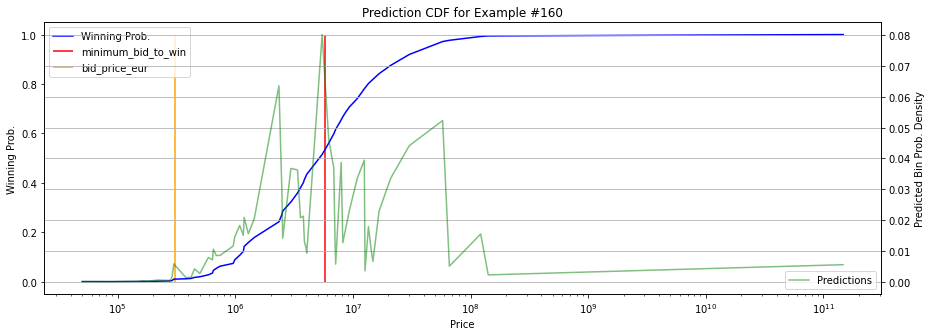

In [587]:
# 
plot_predictions(predictions = predictions, targets = test['win_price'], bids = test['bid_price_eur'], bins = bins, 
                 example = 160, save = False) # 160,196

In [705]:
# whole set /my_censored_binary_loss
calc_prediction_accuracy(predictions=predictions, 
                         targets=test['win_price'], #  Problem: 1st price for losing bids
                         cuts=cuts, 
                         percentile_to_bid=0.5)

0.2359746763958448

In [589]:
win_predictions = model.predict(win_ds)
win_predictions.shape

(11768, 62)

In [590]:
# only winning bids /my_censored_binary_loss
calc_prediction_accuracy(predictions=win_predictions, 
                         targets=test.loc[test.wins==1, 'win_price'], #  True 2nd price
                         cuts=cuts, 
                         percentile_to_bid=0.5)

0.5769884432358939

In [146]:
# win bids proportion in the dataset(based on the wins column)
df.wins.mean()

0.05024981869196657

In [147]:
# win bids proportion in the dataset(based on the adx feedback 1&83 -> win)
1-len(df[(df['adx_loss_reason']== 79)])/len(df)

0.05079077052941949

---

# prediction bins

**`find_prediction_bin()`: finds the exact bin with cumulative predicted prob. ≥ threshold** 
> `percentile_to_bid` = 0.5: which bin should I bid to have a 50% to win? \


In [ ]:
#a = np.array([.2, .3, .2, .3]) # prob. of each bin
#print(a.cumsum())
#find_prediction_bin(a, .5)

In [591]:
def find_prediction_bin(predictions, percentile_to_bid):
    return (predictions.cumsum(axis=-1) < percentile_to_bid).astype(np.int).sum(axis=-1)

pred_bins = find_prediction_bin(predictions, .75)
#pd.DataFrame(pred_bins, columns=['Predicted Bins']).hist(bins=len(cuts)) # bins= no. of bins

In [593]:
(predictions.cumsum(axis = 1) < 0.5).astype(np.int).sum(axis = -1)

array([27, 14, 27, ..., 19, 19, 19])

In [ ]:
predictions

In [594]:
test_bins = test[['bid_price_eur', 'win_price']].apply(lambda x: np.digitize(x, cuts))
test_bins['Prediction'] = find_prediction_bin(predictions, .5)
test_bins

,bid_price_eur,win_price,Prediction
209858,18,39,27
821826,32,40,14
466275,6,55,27
714328,7,17,13
708684,22,40,14
...,...,...,...
152718,0,49,35
973604,0,29,19
436656,0,29,19
287801,0,31,19


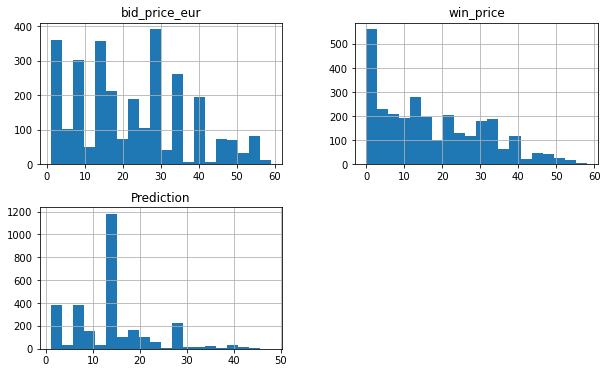

In [595]:
# pict. how's your prediction look like? 
winning = test_bins['bid_price_eur'] > test_bins['win_price']
test_bins.loc[winning].hist(bins=20, figsize=(10,6));

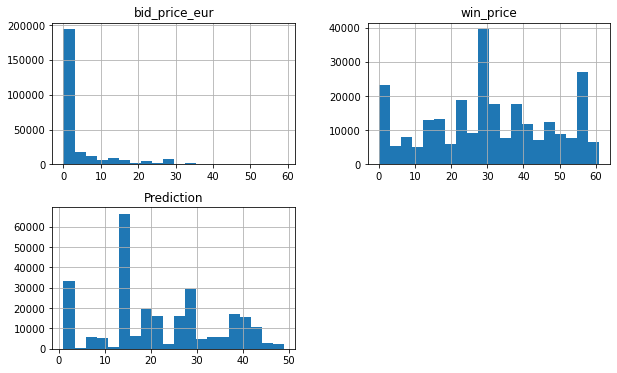

In [596]:
winning = test_bins['bid_price_eur'] > test_bins['win_price']
test_bins.loc[~winning].hist(bins=20, figsize=(10,6));

In [597]:
(test_bins['Prediction'] >= test_bins['win_price']).mean() # This verifies that the calc. is correct

0.2359746763958448

<AxesSubplot:>

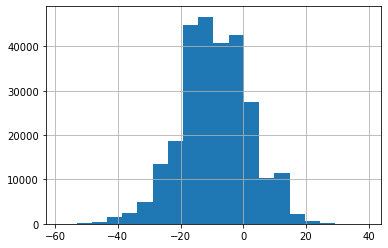

In [598]:
# hist of the diff btw pred and true win_price
# incl. win and lose
(test_bins['Prediction'] - test_bins['win_price']).hist(bins=20)

In [599]:
winning = test_bins['bid_price_eur'] > test_bins['win_price']
# winning = test_bins['Prediction'] >= test_bins['win_price']

print('Avg. overbid (# of bins for winning records): {:.2f}'.format(
          (test_bins.loc[winning, 'Prediction'] - test_bins.loc[winning, 'win_price']).median()),
      '\nAvg. underbid (# of bins for losing recores): {:.2f}'.format(
          (test_bins.loc[~winning, 'Prediction'] - test_bins.loc[~winning, 'win_price']).median()),
      '\n\nWin rate in originally winning bids: {:.2%}'.format(
          (test_bins.loc[winning, 'Prediction'] >= test_bins.loc[winning, 'win_price']).mean()),
      '\nWin rate in originally losing bids: {:.2%}'.format(
          (test_bins.loc[~winning, 'Prediction'] >= test_bins.loc[~winning, 'win_price']).mean())
     )

Avg. overbid (# of bins for winning records): -1.00 
Avg. underbid (# of bins for losing recores): -9.00 

Win rate in originally winning bids: 47.77% 
Win rate in originally losing bids: 23.33%


---

# Country Plot

In [615]:
from matplotlib.pyplot import cm

In [616]:
print(predictions.shape)
predictions

(269156, 62)


array([[0.00387444, 0.00488632, 0.0056569 , ..., 0.00106962, 0.00037772,
        0.00056542],
       [0.03691919, 0.05009366, 0.03926467, ..., 0.00042545, 0.00023301,
        0.00030474],
       [0.0010754 , 0.0008187 , 0.00193446, ..., 0.00046203, 0.00012217,
        0.00025667],
       ...,
       [0.01666436, 0.02309257, 0.02063765, ..., 0.00052581, 0.00024483,
        0.00033346],
       [0.01666436, 0.02309257, 0.02063765, ..., 0.00052581, 0.00024483,
        0.00033346],
       [0.01666436, 0.02309257, 0.02063765, ..., 0.00052581, 0.00024483,
        0.00033346]], dtype=float32)

In [617]:
cuts

array([    50000,     90000,    110000,    140000,    150000,    160000,
          180000,    200000,    220000,    250000,    280000,    290000,
          300000,    380000,    420000,    450000,    500000,    590000,
          640000,    650000,    690000,    740000,    960000,    990000,
         1090000,   1170000,   1190000,   1290000,   1450000,   2350000,
         2490000,   2530000,   2970000,   3380000,   3580000,   3790000,
         3870000,   3970000,   4050000,   5474965,   6230000,   6870000,
         7050000,   7130000,   7950000,   8199999,   8630000,   9350000,
        10890000,  12500000,  12670000,  13550000,  14300000,  14790000,
        16690000,  20930000,  30150000,  57890000,  66067929, 121979183,
       141347565])

In [618]:
pred_cumsum = np.cumsum(predictions, axis=1)

In [619]:
pred_cumsum

array([[0.00387444, 0.00876075, 0.01441765, ..., 0.9990568 , 0.99943453,
        0.99999994],
       [0.03691919, 0.08701285, 0.12627752, ..., 0.99946225, 0.99969524,
        1.        ],
       [0.0010754 , 0.0018941 , 0.00382856, ..., 0.9996213 , 0.99974346,
        1.0000001 ],
       ...,
       [0.01666436, 0.03975692, 0.06039458, ..., 0.99942183, 0.9996667 ,
        1.0000001 ],
       [0.01666436, 0.03975692, 0.06039458, ..., 0.99942183, 0.9996667 ,
        1.0000001 ],
       [0.01666436, 0.03975692, 0.06039458, ..., 0.99942183, 0.9996667 ,
        1.0000001 ]], dtype=float32)

In [620]:
bins.shape

(63,)

In [621]:
pred_cumsum_df.shape

(269156, 87)

In [622]:
pred_cumsum_df = pd.DataFrame.from_records(pred_cumsum,
                          index=test.index, columns=bins[1:])
pred_cumsum_df 

,50000,90000,110000,140000,150000,160000,180000,200000,220000,250000,...,14300000,14790000,16690000,20930000,30150000,57890000,66067929,121979183,141347565,147058830001
209858,0.003874,0.008761,0.014418,0.022792,0.027668,0.033122,0.040019,0.049081,0.059618,0.073023,...,0.986451,0.987157,0.988959,0.991833,0.994959,0.997477,0.997987,0.999057,0.999435,1.0
821826,0.036919,0.087013,0.126278,0.172891,0.192556,0.216781,0.248135,0.278577,0.308797,0.346890,...,0.994904,0.995255,0.995998,0.996964,0.997936,0.998789,0.999037,0.999462,0.999695,1.0
466275,0.001075,0.001894,0.003829,0.006651,0.007815,0.009154,0.011013,0.013473,0.017664,0.022845,...,0.994327,0.994613,0.995398,0.996669,0.998025,0.998983,0.999159,0.999621,0.999743,1.0
714328,0.039078,0.097545,0.150668,0.214402,0.238008,0.267311,0.310004,0.346752,0.382237,0.428890,...,0.995233,0.995593,0.996270,0.997094,0.997908,0.998678,0.998940,0.999408,0.999669,1.0
708684,0.036919,0.087013,0.126278,0.172891,0.192556,0.216781,0.248135,0.278577,0.308797,0.346890,...,0.994904,0.995255,0.995998,0.996964,0.997936,0.998789,0.999037,0.999462,0.999695,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152718,0.000221,0.000353,0.000698,0.001229,0.001716,0.002546,0.003238,0.004287,0.005806,0.007215,...,0.866903,0.871896,0.888079,0.913386,0.944532,0.978274,0.982203,0.993720,0.995740,1.0
973604,0.016664,0.039757,0.060395,0.088179,0.100931,0.115704,0.135135,0.156114,0.177935,0.206677,...,0.993574,0.993976,0.994888,0.996180,0.997515,0.998616,0.998896,0.999422,0.999667,1.0
436656,0.016664,0.039757,0.060395,0.088179,0.100931,0.115704,0.135135,0.156114,0.177935,0.206677,...,0.993574,0.993976,0.994888,0.996180,0.997515,0.998616,0.998896,0.999422,0.999667,1.0
287801,0.016664,0.039757,0.060395,0.088179,0.100931,0.115704,0.135135,0.156114,0.177935,0.206677,...,0.993574,0.993976,0.994888,0.996180,0.997515,0.998616,0.998896,0.999422,0.999667,1.0


In [623]:
tmp = test[list(['country'])]
# pred_cumsum_df.merge(tmp)

In [ ]:
tmp

In [624]:
pred_country_df = tmp.merge(pred_cumsum_df, left_index=True, right_index= True) # used name: pred_country_df= plot_df
pred_country_df

,country,50000,90000,110000,140000,150000,160000,180000,200000,220000,...,14300000,14790000,16690000,20930000,30150000,57890000,66067929,121979183,141347565,147058830001
209858,us,0.003874,0.008761,0.014418,0.022792,0.027668,0.033122,0.040019,0.049081,0.059618,...,0.986451,0.987157,0.988959,0.991833,0.994959,0.997477,0.997987,0.999057,0.999435,1.0
821826,us,0.036919,0.087013,0.126278,0.172891,0.192556,0.216781,0.248135,0.278577,0.308797,...,0.994904,0.995255,0.995998,0.996964,0.997936,0.998789,0.999037,0.999462,0.999695,1.0
466275,ru,0.001075,0.001894,0.003829,0.006651,0.007815,0.009154,0.011013,0.013473,0.017664,...,0.994327,0.994613,0.995398,0.996669,0.998025,0.998983,0.999159,0.999621,0.999743,1.0
714328,jp,0.039078,0.097545,0.150668,0.214402,0.238008,0.267311,0.310004,0.346752,0.382237,...,0.995233,0.995593,0.996270,0.997094,0.997908,0.998678,0.998940,0.999408,0.999669,1.0
708684,us,0.036919,0.087013,0.126278,0.172891,0.192556,0.216781,0.248135,0.278577,0.308797,...,0.994904,0.995255,0.995998,0.996964,0.997936,0.998789,0.999037,0.999462,0.999695,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152718,us,0.000221,0.000353,0.000698,0.001229,0.001716,0.002546,0.003238,0.004287,0.005806,...,0.866903,0.871896,0.888079,0.913386,0.944532,0.978274,0.982203,0.993720,0.995740,1.0
973604,us,0.016664,0.039757,0.060395,0.088179,0.100931,0.115704,0.135135,0.156114,0.177935,...,0.993574,0.993976,0.994888,0.996180,0.997515,0.998616,0.998896,0.999422,0.999667,1.0
436656,us,0.016664,0.039757,0.060395,0.088179,0.100931,0.115704,0.135135,0.156114,0.177935,...,0.993574,0.993976,0.994888,0.996180,0.997515,0.998616,0.998896,0.999422,0.999667,1.0
287801,us,0.016664,0.039757,0.060395,0.088179,0.100931,0.115704,0.135135,0.156114,0.177935,...,0.993574,0.993976,0.994888,0.996180,0.997515,0.998616,0.998896,0.999422,0.999667,1.0


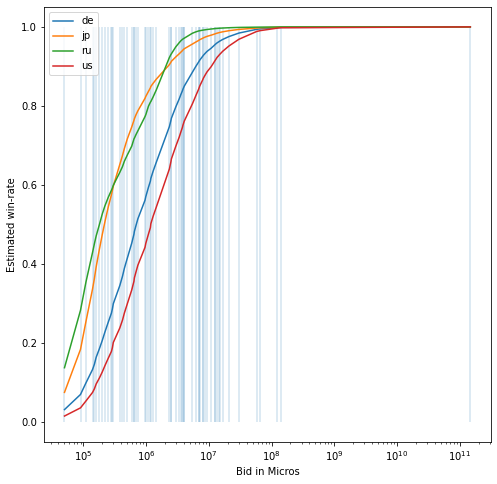

In [625]:
# delet
ax = pred_country_df.groupby('country').mean().T.plot(figsize=(8, 8))
ax.set_xscale('log')
plt.vlines(bins, 0, 1, alpha=0.2)
plt.xlabel('Bid in Micros')
plt.ylabel('Estimated win-rate')
plt.legend();

# bins = 295
# minimum_bid_to_win

In [626]:
nth_bin= np.digitize(test['win_price'],bins)
test_bin = tf.one_hot(nth_bin, len(bins))
print(test_bin.shape)


actual_cumsum = np.cumsum(test_bin, axis=1)
print(actual_cumsum.shape)

(269156, 63)
(269156, 63)


In [627]:
actual_cumsum_df = pd.DataFrame.from_records(actual_cumsum,index=test.index, columns=bins[0:])

# merge country
actual_cumsum_df = tmp.merge(actual_cumsum_df, left_index=True, right_index= True)

In [628]:
actual_cumsum_df

,country,0,50000,90000,110000,140000,150000,160000,180000,200000,...,14300000,14790000,16690000,20930000,30150000,57890000,66067929,121979183,141347565,147058830001
209858,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
821826,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
466275,ru,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
714328,jp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
708684,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152718,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
973604,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
436656,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
287801,us,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
actual_cumsum_df.groupby('country').mean().T.columns

In [ ]:
actual_cumsum_df.groupby('country').mean().index.shape[0]

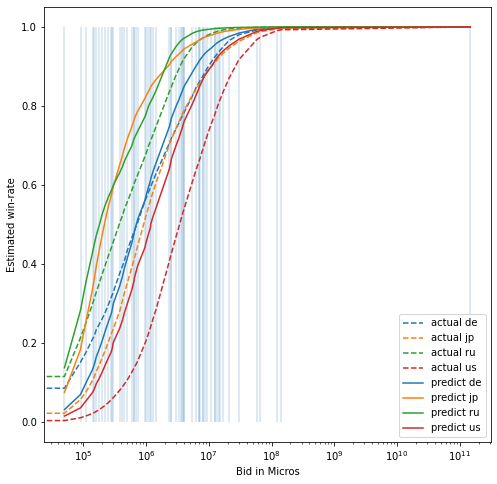

In [629]:
from matplotlib.pyplot import cm
color = cm.Set1
color


temp = actual_cumsum_df.groupby('country').mean().T
temp.columns = ['actual '+s for s in temp.columns]
ax = temp.plot(linestyle='dashed')
ax.set_prop_cycle(None)

temp = pred_country_df.groupby('country').mean().T
temp.columns = ['predict '+s for s in temp.columns]
temp.plot(linestyle='-', ax=ax, figsize=(8,8))

ax.set_xscale('log')

plt.vlines(bins, 0, 1, alpha=0.2)
plt.xlabel('Bid in Micros')
plt.ylabel('Estimated win-rate');



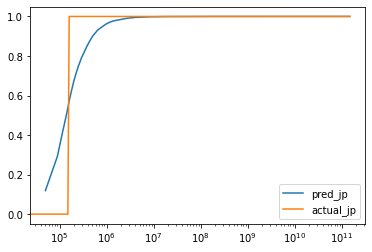

In [704]:
# only plot japan because the mean cdf plot for japen seems not well predicted

pred_cdf_jp = pred_country_df[pred_country_df['country'] == 'jp'].set_index('country')
actural_cdf_jp = actual_cumsum_df[actual_cumsum_df['country'] == 'jp'].set_index('country')

ax = pred_cdf_jp.iloc[10].T.plot() # kind = 'kde' for checking pdf
ax.set_xscale('log')

ax = actural_cdf_jp.iloc[10].T.plot(ax=ax) # kind = 'kde'
ax.set_xscale('log')

ax.legend(["pred_jp", "actual_jp"])


---

# Test for Lognormal

In [514]:
#!pip install --upgrade tensorflow-probability

Looking in indexes: http://api1.dw1.remerge.io:31337/simple, https://pypi.org/simple


In [517]:
import tensorflow_probability as tfp

In [522]:
loc = 1
scale = 1

LN = tfp.distributions.LogNormal(
    loc, scale, validate_args=False, allow_nan_stats=True,
    name='LogNormal')

In [523]:
LN.prob([1,2,3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.24197073, 0.19029781, 0.13233575], dtype=float32)>